# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
- **Ревизия**: 8

- **Другие ревизии**: [ссылка](https://disk.yandex.ru/d/aZozDpBlzh_z1A)
<!-- please do not append text into this block -->

- [x] Добавить 2x больше эпох на датасетах, где был плохой перфоманс (1, 2, 5, 7, 8)
- [x] Примешивать к целевой переменной на этапе обучения шум с амплитудой ~0,03 дисперсии
- [x] Обучить модели без шума для сравнения
- [ ] Отображать правильную шкалу шума
- [x] Подмешивать стабильно распределённый шум, варьируя $\alpha$ от 1 до 2

NOTE: levy distribution нам не подходит, у него фиксированная $\alpha = 0.5$


## Setup

In [ ]:
from cgtnnlib.constants import LEARNING_RATE, RANDOM_STATE
import cgtnnlib.training as tr
import cgtnnlib.datasets as ds
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.NoiseGenerator import target_dispersion_scaled_noise, stable_noise, no_noise_generator


iterations = 10
epochs = 10
pp = [0.0, 0.5, 0.9]

double_epochs_datasets = [
    ds.datasets[0], # 1
    ds.datasets[1], # 2
    ds.datasets[4], # 5
    ds.datasets[6], # 7
    ds.datasets[7], # 8
]

datasets = ds.datasets

datasets = [
    ds.datasets[0], # 1
    ds.datasets['StudentPerformanceFactors'],
    ds.datasets['allhyper'],
    ds.datasets['wine_quality'],
]

ng_makers = [
    lambda _: no_noise_generator,
    lambda dataset: target_dispersion_scaled_noise(
        dataset=dataset,
        factor=0.03,
        random_seed=RANDOM_STATE + 1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.12,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.25,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.5,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.75,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=2.0,
        beta=1,
    ),
]

TORCH_DEVICE is cpu


In [37]:

ng_makers[0](datasets[0]).next_sample()

0


## Генерация стабильного шума

Используется алгоритм Chambers-Mallows-Stuck (CMS) [1]; в [2] алгоритм дан в прямом виде. Реализация в файле *cgtnnlib/NoiseGenerator.py*.

In [38]:
ng = stable_noise(
    dataset=datasets[0],
    factor=0.03,
    alpha=1,
    beta=0.0
)

print(ng.name)
[ng.next_sample() for _ in range(10)]

Stable1A1B0.0F0.03


[-0.005279588669174442,
 0.0031930501306324218,
 -0.035075205006525584,
 0.006596254315176364,
 -0.007616876775682892,
 -0.0014256312065177182,
 0.0023231485608523,
 -0.027976844253626627,
 -0.1325666989224497,
 0.0003374316519907252]

In [39]:
dataset = ds.datasets['StudentPerformanceFactors']
dataset.data.df[dataset.target].std() ** 2

15.215720060424232

## Training

- both take ~5m 06s to train 10 iterations
- both on both noises: about ~10m

<hr>

- `ds.datasets['StudentPerformanceFactors']` takes ~2m 30s to train 10 iterations
- `ds.datasets['wine_quality']` takes ~2m 36s to train 10 iterations

<hr>

- `ds.datasets['allhyper']` takes ~36m to train on all noise generators

In [2]:
for i, dataset in enumerate(datasets):
    for ng_maker in ng_makers:
        for p in pp:
            noise_generator = ng_maker(dataset)
            for iteration in range(iterations):
                tr.create_and_train_model(
                    dataset,
                    epochs * 2 if dataset in double_epochs_datasets else epochs,
                    learning_rate=LEARNING_RATE,
                    dry_run=False,
                    p=p,
                    iteration=iteration,
                    noise_generator=noise_generator,
                    must_not_exist=True
                )

File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N1.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N2.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N3.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N4.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N5.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N6.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N7.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N8.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N9.pth. Skipping training.
File alrea

```python
IndexError: Target 106 is out of bounds.

        TORCH_CHECK_INDEX(
            cur_target >= 0 && cur_target < n_classes,
            "Target ",
            cur_target,
            " is out of bounds.");
```

https://github.com/pytorch/pytorch/blob/4106aa33eb2946bf67f4ffd2ad9f2dcb52ed2384/aten/src/ATen/native/LossNLL.cpp#L192

## Evaluation

Теперь Evaluation происходит в Analysis

<!-- both take 42s

120 take 4m 10.9s

(need evaluation skip check??)
 -->


In [ ]:
# from cgtnnlib.EvaluationParameters import EvaluationParameters
# from cgtnnlib.Report import Report
# from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork
# import cgtnnlib.evaluate as ev
# import cgtnnlib.datasets as ds
# import cgtnnlib.path as ph
# from cgtnnlib.ExperimentParameters import ExperimentParameters

# ## All others
# for i, dataset in enumerate(datasets):
#     for ng_maker in ng_makers:
#         for p in pp:
# ## 2x epochs
# # for i, dataset in enumerate(double_epochs_datasets):
# #     for p in pp:
# #         for iteration in range(iterations):
            
#             ## All others

#             noise_generator = ng_maker(dataset)
            
#             ## 2x epochs
            
#             # noise_generator = no_noise_generator

#             for iteration in range(iterations):
#                 experiment_params = ExperimentParameters(iteration, p=p)

#                 model_path = ph.model_path(
#                     dataset_number=dataset.number,
#                     model_type=AugmentedReLUNetwork,
#                     p=p,
#                     iteration=iteration,
#                     noise_generator=noise_generator,
#                 )

#                 eval_params = EvaluationParameters(
#                     dataset=dataset,
#                     model_path=model_path,
#                     experiment_parameters=experiment_params,
#                     report_key=ph.eval_report_key(
#                         model_name=AugmentedReLUNetwork.__name__,
#                         dataset_number=dataset.number,
#                         p=p,
#                         iteration=iteration,
#                     )
#                 )
                
#                 report_name = ph.model_name(
#                     dataset_number=dataset.number,
#                     model_type=AugmentedReLUNetwork,
#                     p=p,
#                     iteration=iteration,
#                     noise_generator=noise_generator
#                 )
                
#                 report = Report(
#                     dir='pth/',
#                     filename=report_name + '.json',
#                     must_exist=True,
#                 )
                
#                 ev.eval_inner(
#                     eval_params=eval_params,
#                     constructor=AugmentedReLUNetwork,
#                     report=report
#                 )
                
#                 report.save()

Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
Report saved to pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N0.json.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
Report saved to pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N1.json.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
Report saved to pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N2.json.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
Report saved to pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N3.json.
Report found at pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1B1F0.03-P0.0_N4.json. Loading...
Report loaded.
Skipping evaluation.
Report saved to pth/cgtnn-3

## Analysis

Чтобы всё отрисовалось, нужно запустить два раза

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N4.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-

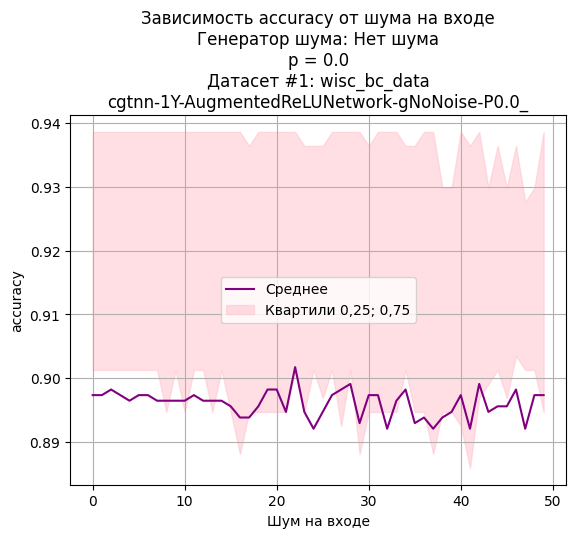

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N4.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N4.json 4
Report found at

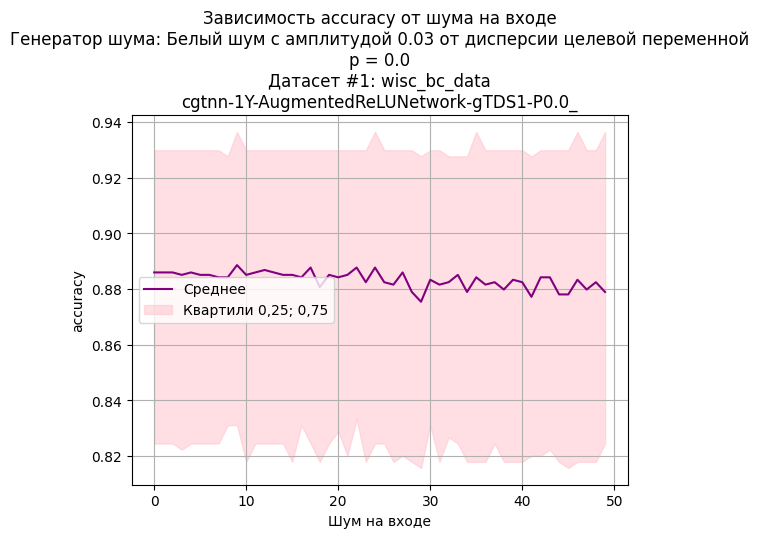

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N4.json. Loading...
Report loaded.
Skipping

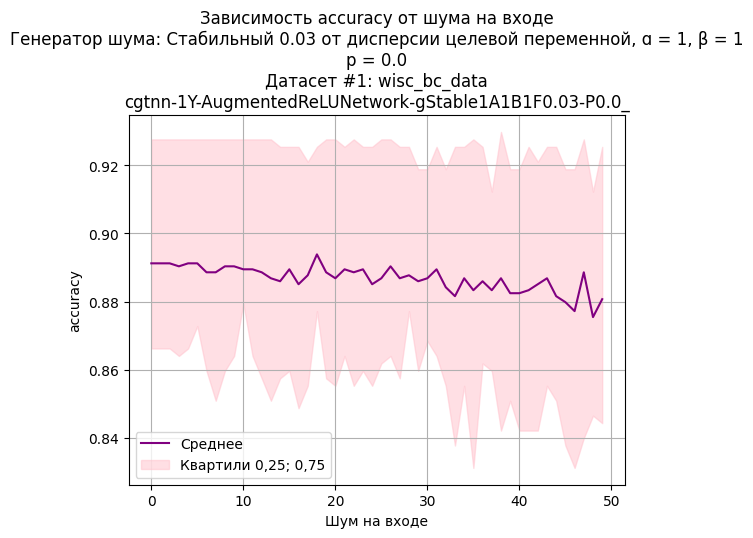

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N4.json. Loading

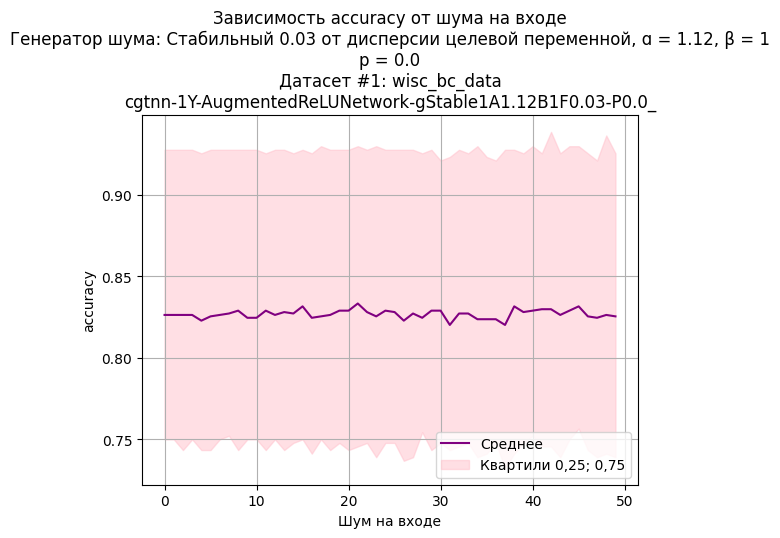

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N4.json. Loading

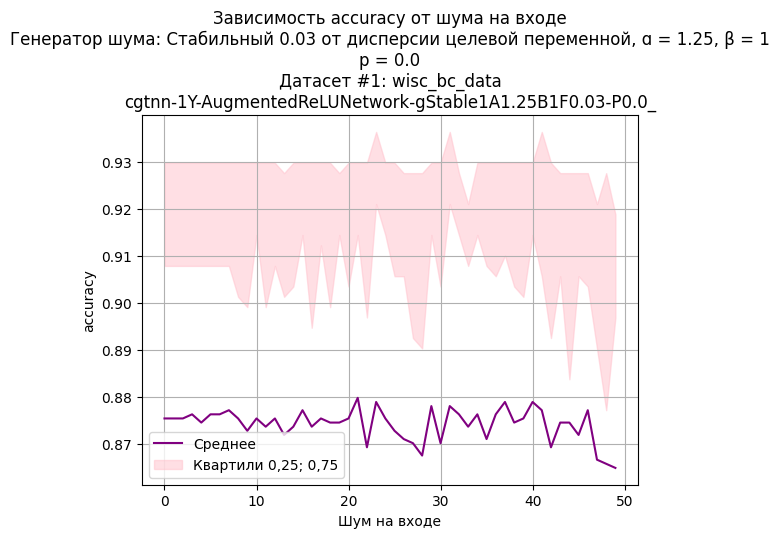

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.0_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.0_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.0_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.0_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.0_N4.json. Loading...
Repor

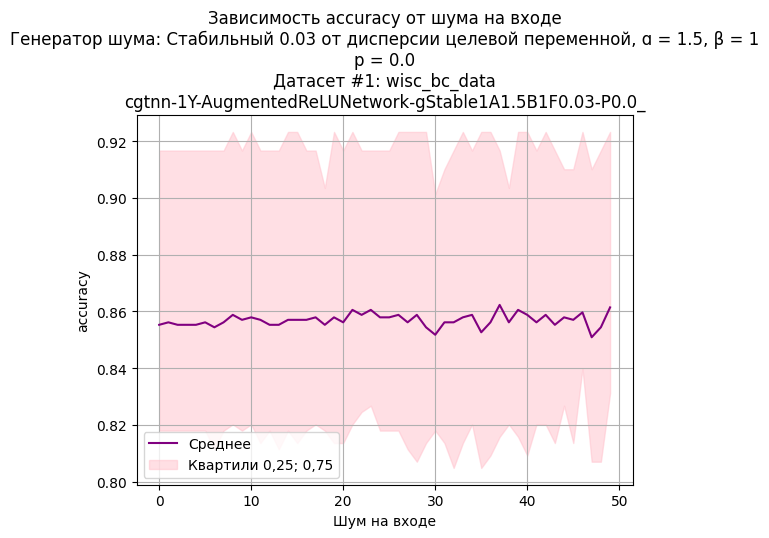

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.0_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.0_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.0_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.0_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.0_N4.json. Loading

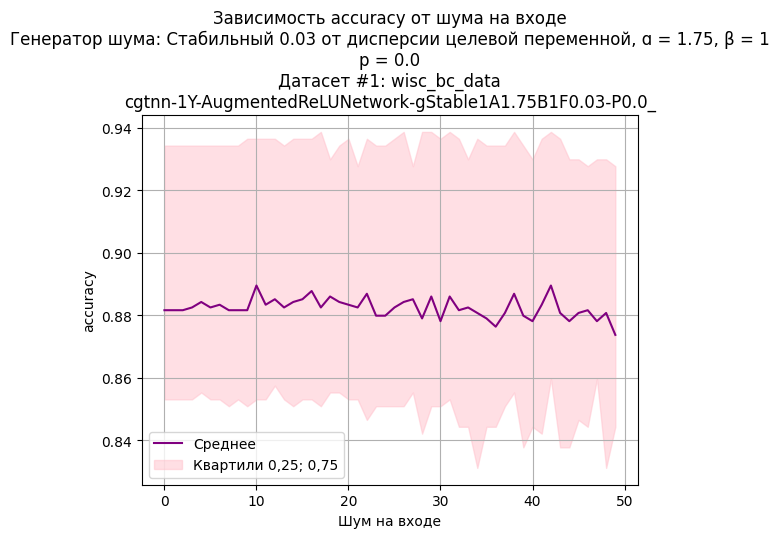

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.0_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.0_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.0_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.0_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.0_N4.json. Loading...
Repor

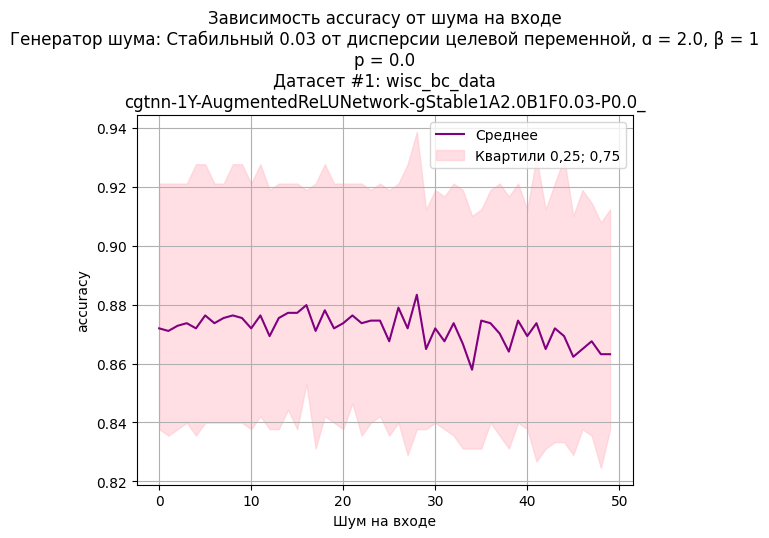

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N4.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-

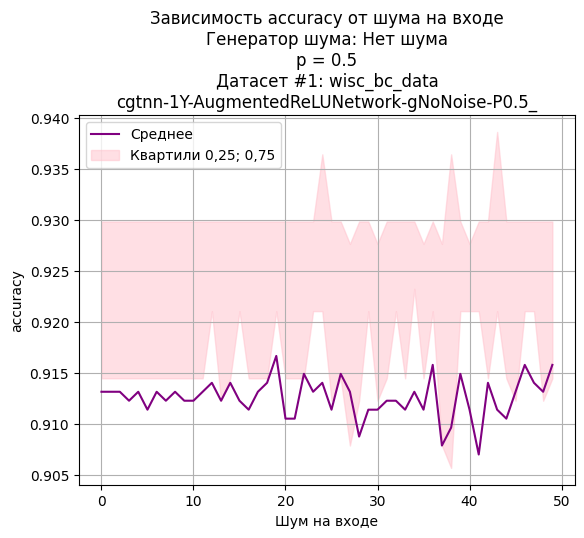

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N4.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N4.json 4
Report found at

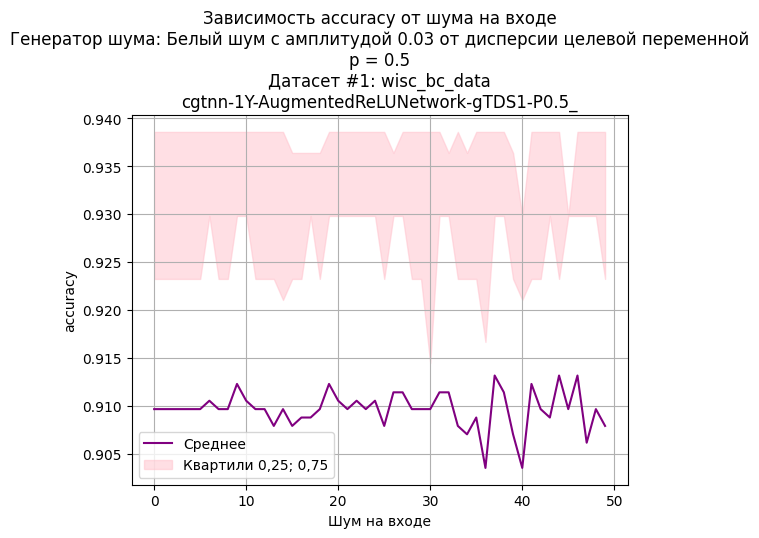

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N4.json. Loading...
Report loaded.
Skipping

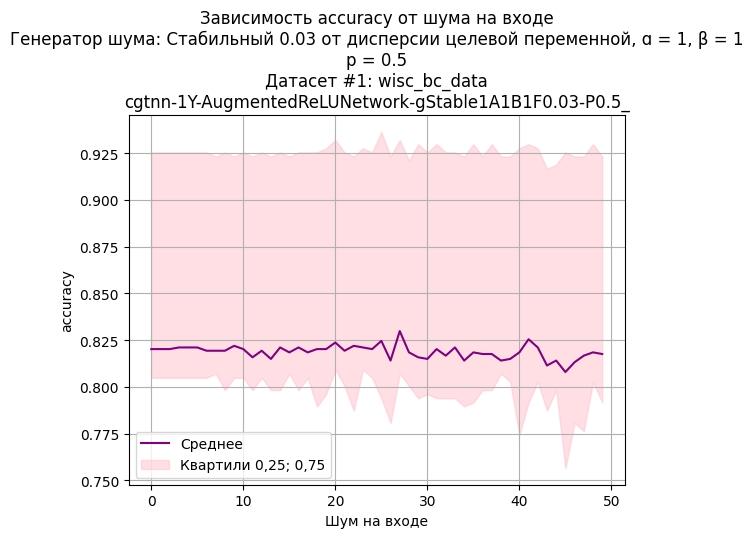

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N4.json. Loading

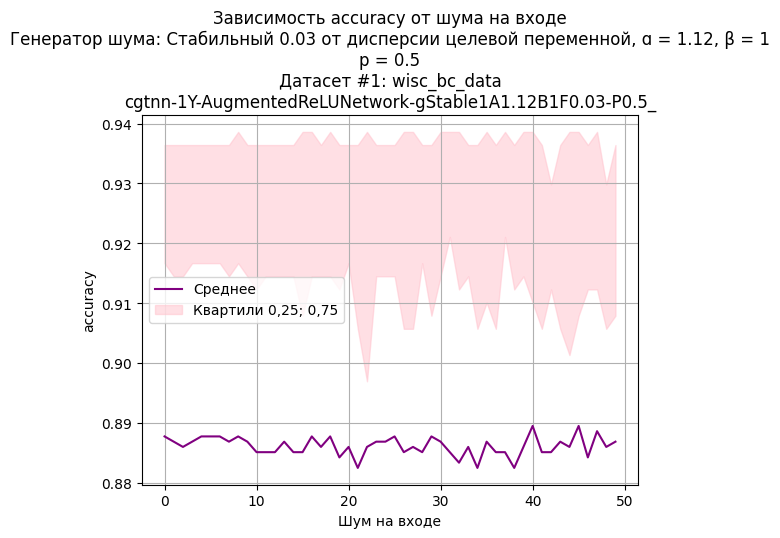

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.5_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.5_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.5_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.5_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.5_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.5_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.5_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.5_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.5_N4.json. Loading

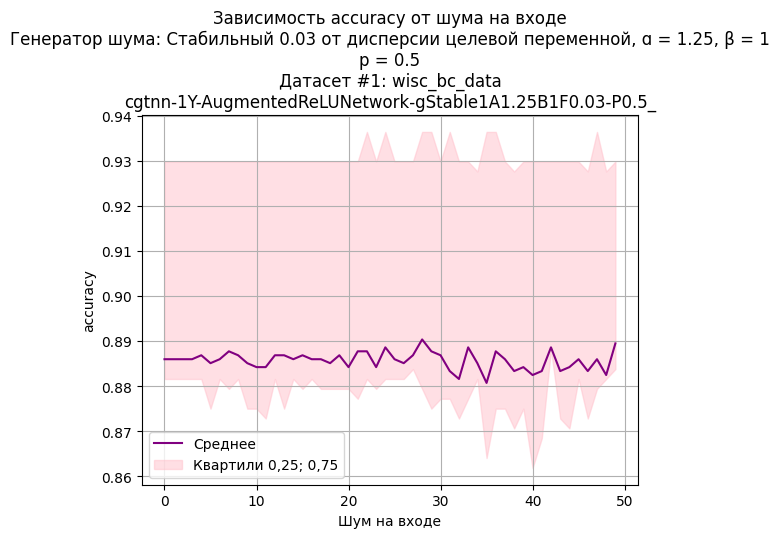

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.5_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.5_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.5_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.5_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.5_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.5_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.5_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.5_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.5_N4.json. Loading...
Repor

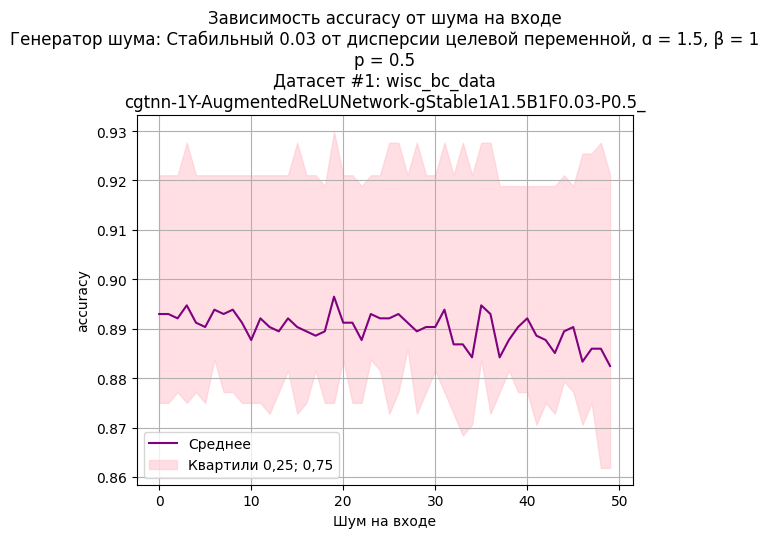

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.5_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.5_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.5_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.5_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.5_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.5_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.5_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.5_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.5_N4.json. Loading

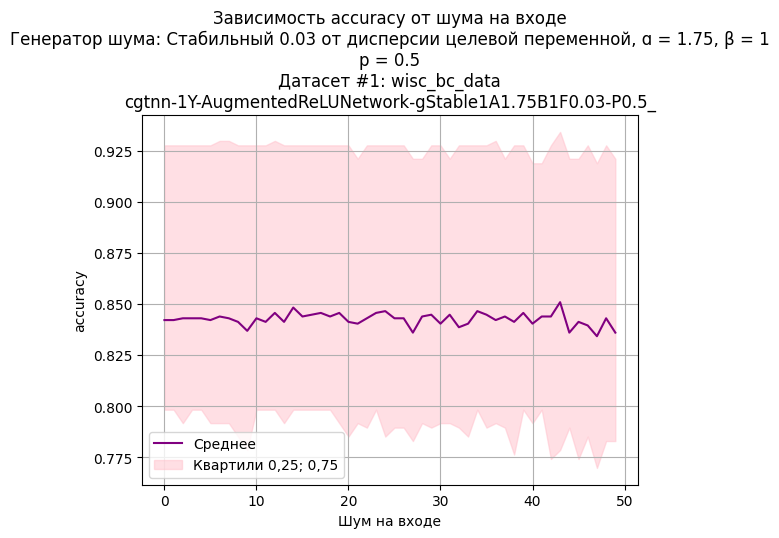

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.5_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.5_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.5_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.5_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.5_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.5_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.5_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.5_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.5_N4.json. Loading...
Repor

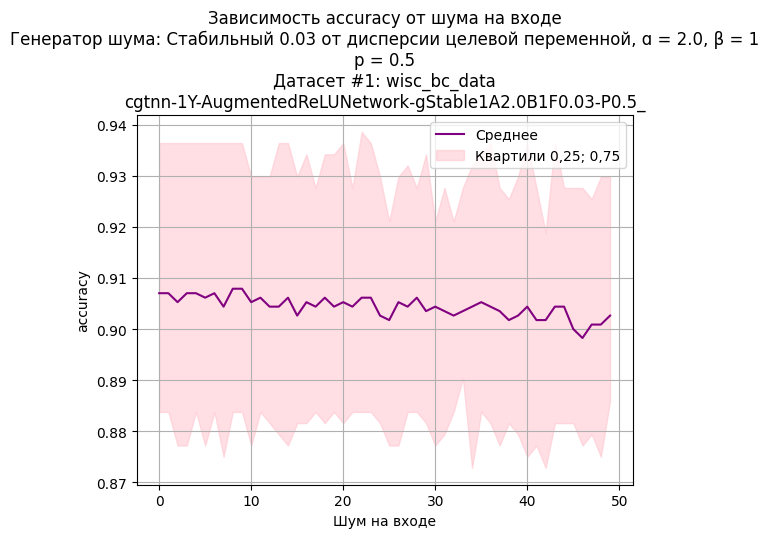

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N4.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-

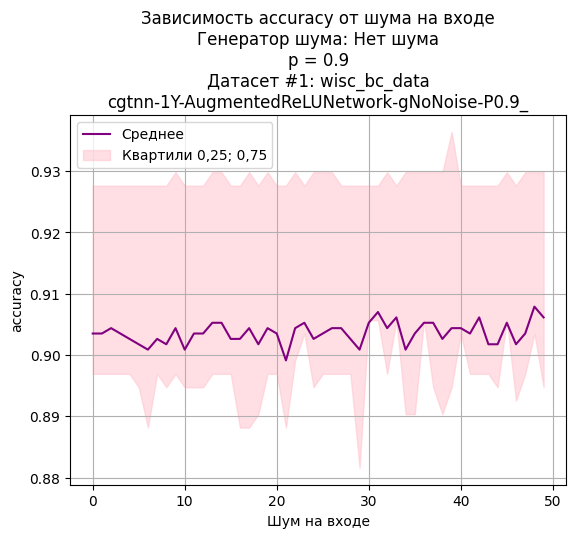

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N4.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N4.json 4
Report found at

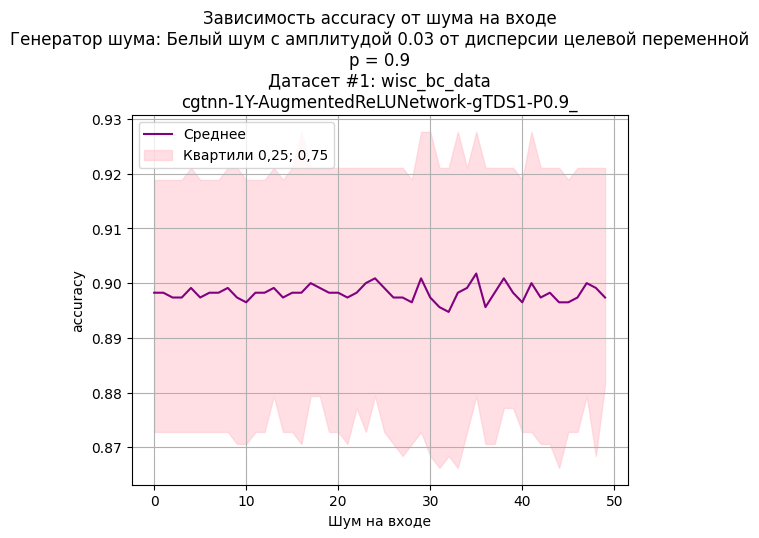

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N4.json. Loading...
Report loaded.
Skipping

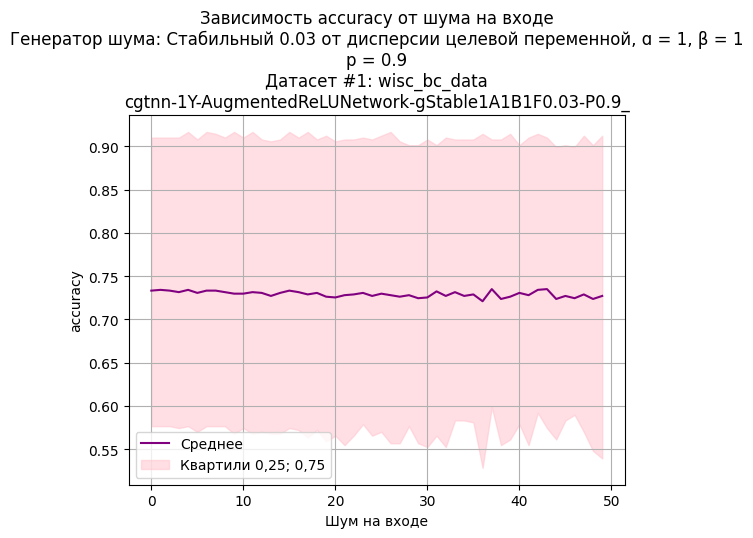

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N4.json. Loading

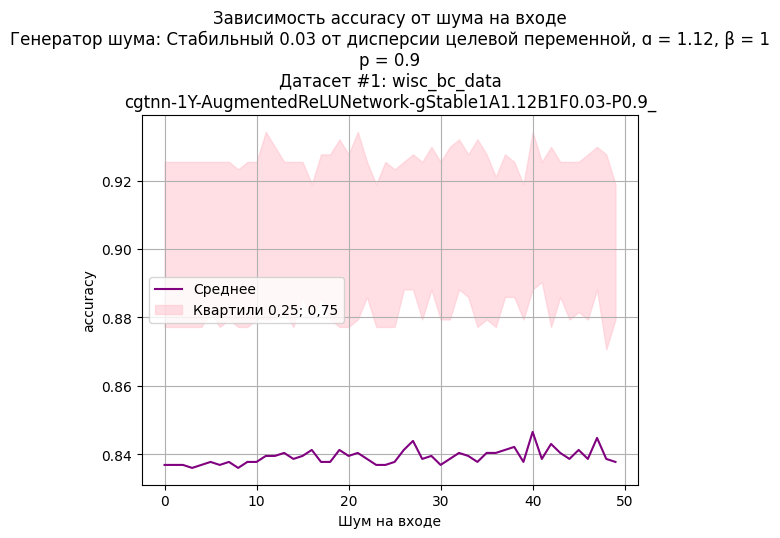

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.9_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.9_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.9_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.9_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.9_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.9_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.9_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.9_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.9_N4.json. Loading

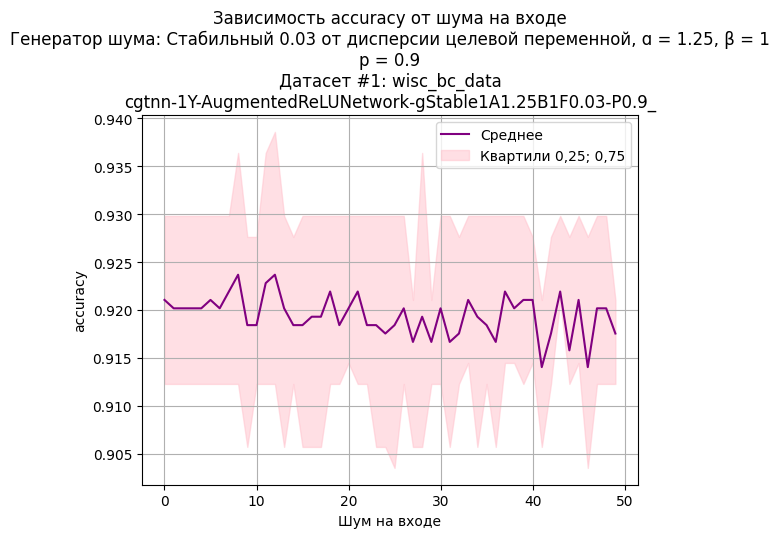

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.9_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.9_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.9_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.9_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.9_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.9_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.9_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.9_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.5B1F0.03-P0.9_N4.json. Loading...
Repor

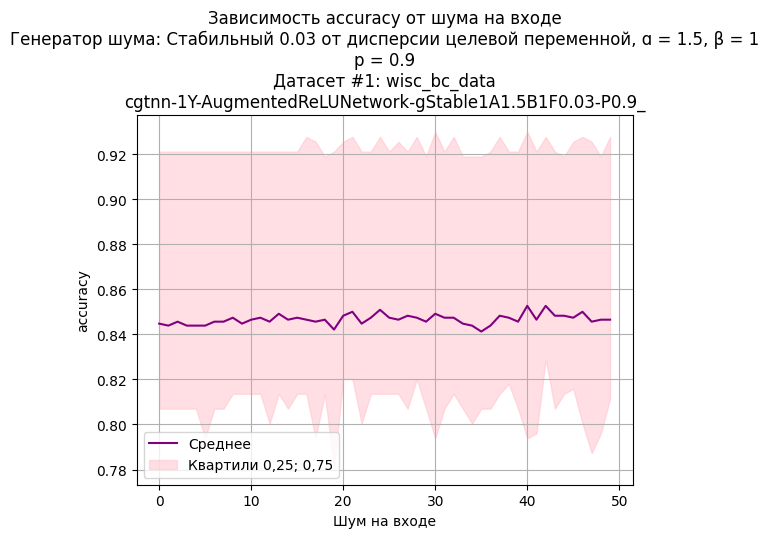

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.9_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.9_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.9_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.9_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.9_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.9_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.9_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.9_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.75B1F0.03-P0.9_N4.json. Loading

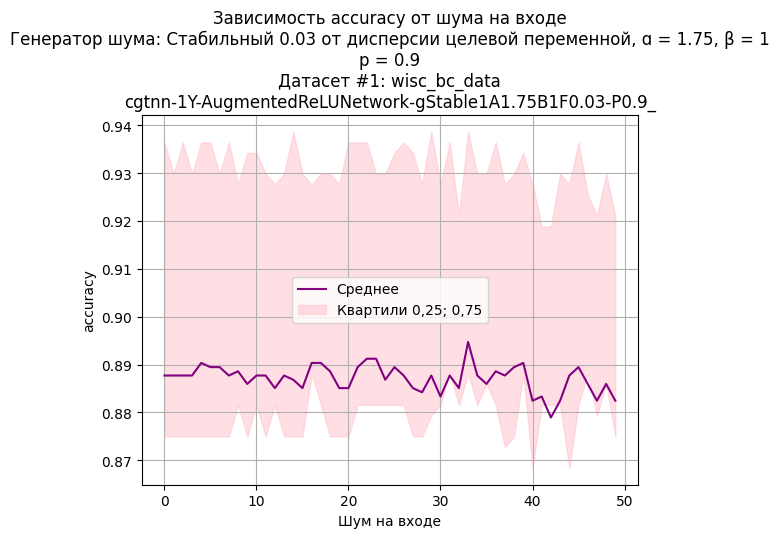

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.9_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.9_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.9_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.9_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.9_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.9_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.9_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.9_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A2.0B1F0.03-P0.9_N4.json. Loading...
Repor

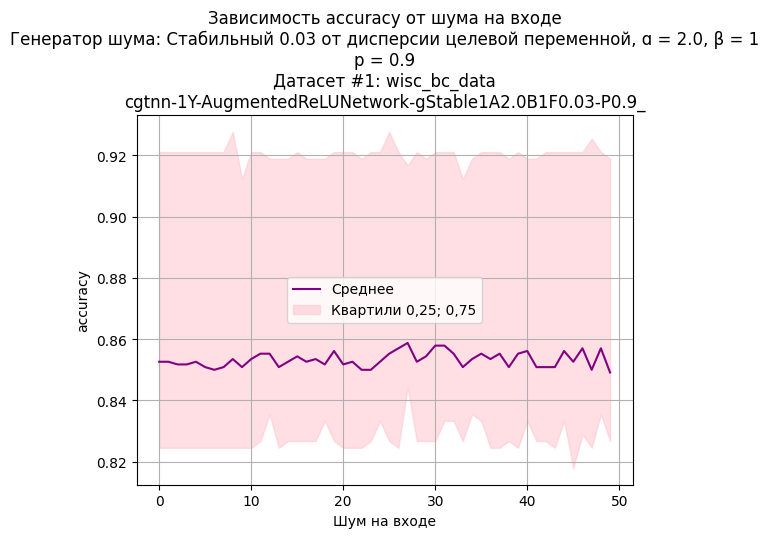

In [8]:
## Analysis

import json

import pandas as pd

import matplotlib.pyplot as plt

from cgtnnlib.LearningTask import is_classification_task
from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt
from cgtnnlib.evaluate import eval_report_at_path
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork



def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)

def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame({
        0.25: df.quantile(0.25, axis=1),
        0.75: df.quantile(0.75, axis=1),
        'mean': df.mean(axis=1),
    })

    return summary_df

#for i, dataset in enumerate(double_epochs_datasets):
for i, dataset in enumerate(datasets):
    for p in pp:
        for ng_maker in ng_makers:
            noise_generator = ng_maker(dataset)
            prefix = (
                f'cgtnn-{dataset.number}Y-AugmentedReLUNetwork'
                +f'-g{noise_generator.name}-P{p}_'
            )

            if is_classification_task(dataset.learning_task):
                metric = 'accuracy'
            else:
                metric = 'r2'

            def report_path(n):
                return f'pth/{prefix}N{n}.json'

            def model_path(n):
                return f'pth/{prefix}N{n}.pth'

            def read_eval_from_iteration(n) -> pd.DataFrame:
                path = report_path(n)
                eval_report_at_path(
                    report_path=path,
                    model_path=model_path(n),
                    constructor=AugmentedReLUNetwork,
                    dataset=dataset,
                    p=p,
                )
                print('read_eval_from_iteration', path, n)
                return pd.DataFrame(read_json(path)['eval'])

            files = [
                read_eval_from_iteration(n)
                for n in range(iterations)
            ]
            
            print(report_path(0))

            double_epochs = summarize_series_list([file[metric] for file in files])

            plot_deviant_curves_on_ax_or_plt(
                ax_or_plt=plt,
                models=[{
                    'curve': double_epochs,
                    'color': 'purple',
                    'label': 'Среднее',
                    'quantiles_color': 'pink',
                    'quantiles_label': 'Квартили 0,25; 0,75', 
                }],
                title='\n'.join([
                    # 'Кривая потерь, обучение с +0.03 шумом на входе',
                    f'Зависимость {metric} от шума на входе',
                    f'Генератор шума: {noise_generator.description}',
                    f'p = {p}',
                    f'Датасет #{dataset.number}: {dataset.name}',
                    prefix,
                ]),
                xlabel='Шум на входе',
                ylabel=metric,
                quantiles_alpha=0.5,
            )
            plt.show()

Fails on pth/cgtnn-3Y-AugmentedReLUNetwork-gStable3A1.25B1F0.03-P0.0_N0.json

## References

1. Chambers, J. M., Mallows, C. L., & Stuck, B. W. (1976). A method for simulating stable random variables. *Journal of the American Statistical Association*, *71*(354), 340-344.
2. M. Firouzi, A. Mohammadpour. A Survey on Simulating Stable Random Variables. URL: https://www.semanticscholar.org/reader/11a1e93642dc0a5c94e6906bcca5e4d25d4e9d46